In [32]:
import numpy as np
import pandas as pd
import torch
import torchvision
import xml.etree.ElementTree as ET
import random
import os
import cv2
import matplotlib.pyplot as plt
import albumentations as A
import shutil

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

!pip install torchmetrics[detection]
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from pathlib import Path
from IPython.display import display, clear_output
from pprint import pprint

import xml.etree.ElementTree as ET

import glob

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 18.8 MB/s eta 0:00:00


In [2]:
!pip install ultralytics
from ultralytics import YOLO

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 29.6 MB/s eta 0:00:00


In [3]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d andrewmvd/face-mask-detection
! unzip -q face-mask-detection

 96% 380M/398M [00:03<00:00, 157MB/s]
100% 398M/398M [00:03<00:00, 120MB/s]


In [6]:
# Matplotlib figures with white background, not transparent
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

In [7]:
# Assigning the GPU for computations, if it exists
# (actually with CPU one is going to calculate it to the end of time)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
!mkdir saved
!mkdir working

In [9]:
DATA = Path(
    "/content")
SAVED_RESULTS = Path(
    '/content/saved')
WORKING = Path(
    '/content/working')
# YOLO_DATA =  Path(
#     '/kaggle/working/yolov8')



In [10]:
anns = glob.glob(os.path.join("/content/annotations/*.xml"))

In [11]:
for file in sorted(anns):
        print(file)
        tree = ET.parse(file)
        root = tree.getroot()
        for obj in root.findall('object'):
            bbx = obj.find("bndbox")
            xmin = int(bbx.find("xmin").text)
            print(bbx)
            break
        break

/content/annotations/maksssksksss0.xml
<Element 'bndbox' at 0x7f305c38d990>


In [12]:
def xml_to_df(path=DATA/'annotations'):
    xml_list = []
    for file in tqdm(sorted(path.glob('*.xml'))):
        tree = ET.parse(file)
        root = tree.getroot()
        imsize = root.find('size')
        width = int(imsize.find('width').text)
        height = int(imsize.find('height').text)

        for obj in root.findall('object'):
            bbx = obj.find("bndbox")
            xmin = int(bbx.find("xmin").text)
            ymin = int(bbx.find("ymin").text)
            xmax= int(bbx.find("xmax").text)
            ymax = int(bbx.find("ymax").text)
            label = obj.find("name").text
            value = (root.find('filename').text,
                     width,
                     height,
                     xmin,
                     ymin,
                     xmax,
                     ymax,
                     label)
            xml_list.append(value)
    columns = [
        'filename', 'width', 'height', 'xmin','ymin', 'xmax', 'ymax', 'class'
    ]
    xml_df = pd.DataFrame(xml_list, columns = columns)

    # Some bboxes are out of an image by 1 pixel, correcting
    xml_df['xmax'] = xml_df.apply(
    lambda x: x['width'] if x['xmax'] > x['width'] else x['xmax'],axis =1)

    # Drop tiny bboxes
    xml_df['area'] = ((xml_df['xmax'] - xml_df['xmin']) *
                      (xml_df['ymax'] - xml_df['ymin']))
    xml_df = xml_df[xml_df['area'] > 20]
    return xml_df

bboxes_df = xml_to_df()
display(bboxes_df.head)
print(f"number of images : {bboxes_df['filename'].nunique()}")
print(f"number of objects : {bboxes_df.shape[0]}\n")
nobj_in_class = bboxes_df.groupby('class')['xmin'].count()
print(nobj_in_class)

100%|██████████| 853/853 [00:00<00:00, 8987.81it/s]


<bound method NDFrame.head of                 filename  width  height  xmin  ymin  xmax  ymax  \
0      maksssksksss0.png    512     366    79   105   109   142   
1      maksssksksss0.png    512     366   185   100   226   144   
2      maksssksksss0.png    512     366   325    90   360   141   
3      maksssksksss1.png    400     156   321    34   354    69   
4      maksssksksss1.png    400     156   224    38   261    73   
...                  ...    ...     ...   ...   ...   ...   ...   
4067  maksssksksss98.png    400     267   263    62   287    85   
4068  maksssksksss98.png    400     267   344    80   377   106   
4069  maksssksksss99.png    400     267   181    54   273   162   
4070  maksssksksss99.png    400     267    99    87   176   165   
4071  maksssksksss99.png    400     267   289    99   355   233   

                      class  area  
0              without_mask  1110  
1                 with_mask  1804  
2              without_mask  1785  
3                 wit

number of images : 853
number of objects : 4054

class
mask_weared_incorrect     123
with_mask                3216
without_mask              715
Name: xmin, dtype: int64


<BarContainer object of 3 artists>

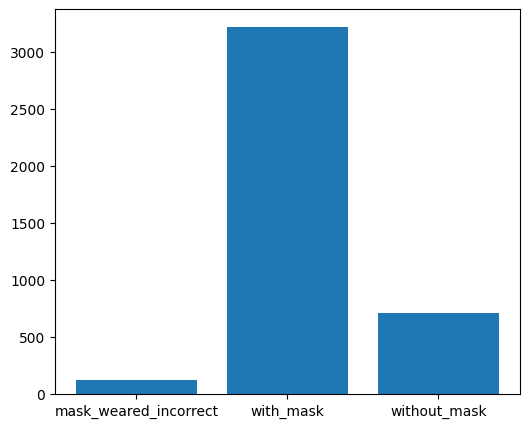

In [13]:
fig, ax = plt.subplots(figsize= (6,5))
plt.bar(nobj_in_class.index, nobj_in_class)

In [14]:
# weighted loading data during model training
wdict = {'with_mask' : 1-3216/4054,
         'without_mask' : 1-715/4054,
         'mask_weared_incorrect' : 1-123/4054
         }
bboxes_df['im_weight'] = bboxes_df['class'].replace(wdict)
bboxes_df['im_weight'] = (bboxes_df.groupby('filename')['im_weight'].transform('mean'))
# one file can contain several different classes, the "mean inverse probability" per image is calculated

In [15]:
bboxes_df

,filename,width,height,xmin,ymin,xmax,ymax,class,area,im_weight
0,maksssksksss0.png,512,366,79,105,109,142,without_mask,1110,0.617990
1,maksssksksss0.png,512,366,185,100,226,144,with_mask,1804,0.617990
2,maksssksksss0.png,512,366,325,90,360,141,without_mask,1785,0.617990
3,maksssksksss1.png,400,156,321,34,354,69,with_mask,1155,0.275256
4,maksssksksss1.png,400,156,224,38,261,73,with_mask,1295,0.275256
...,...,...,...,...,...,...,...,...,...,...
4067,maksssksksss98.png,400,267,263,62,287,85,with_mask,552,0.206709
4068,maksssksksss98.png,400,267,344,80,377,106,with_mask,858,0.206709
4069,maksssksksss99.png,400,267,181,54,273,162,mask_weared_incorrect,9936,0.461026
4070,maksssksksss99.png,400,267,99,87,176,165,with_mask,6006,0.461026


Notice that Faster R-CNN is trained in such a way that its weights "know" about a special background class, and this class is labelled 0. Therefore we must assign our custom labels starting from 1, otherwise the model will simply ignore the "zero" class. This is not very clear from the official PyTorch documentation.

In [16]:
encoder = LabelEncoder()
bboxes_df['label'] = encoder.fit_transform(bboxes_df['class'])
bboxes_df['label'] = bboxes_df['label'] + 1 #Faster-RNN use 0 for background

# Zip dict {1: 'mask_weared_incorrect', 2: 'with_mask', 3: 'without_mask'}
labels_dict = dict(zip(range(1, len(encoder.classes_) + 1), encoder.classes_))
# Categorical image type based on the weight range
bboxes_df['im_type'] = (bboxes_df['im_weight'].astype(str).apply(lambda x: x[:3]))
# Splitting by filename and weight range
unique_name_df = bboxes_df[['filename', 'im_type']].drop_duplicates() #853 rows left
train_fnames, valid_fnames = train_test_split(unique_name_df, train_size= 0.8, stratify= unique_name_df['im_type'], random_state= 42)
train_df = (bboxes_df[bboxes_df['filename'].isin(train_fnames['filename'])].copy())
valid_df = (bboxes_df[bboxes_df['filename'].isin(valid_fnames['filename'])].copy())

print('Training dataset:')
print(f"Numbers of images: {train_df['filename'].nunique()}")
print(f"Numbers of objects: {train_df.shape[0]}\n")
print('Validation dataset:')
print(f"Numbers of images: {valid_df['filename'].nunique()}")
print(f"Numbers of objects: {valid_df.shape[0]}\n")
print(valid_df.groupby('class')['xmin'].count()/len(valid_df))

Training dataset:
Numbers of images: 682
Numbers of objects: 3312

Validation dataset:
Numbers of images: 171
Numbers of objects: 742

class
mask_weared_incorrect    0.024259
with_mask                0.776280
without_mask             0.199461
Name: xmin, dtype: float64


In [17]:
transform_train = A.Compose([
    A.HorizontalFlip(),
    A.OneOf([
        A.ColorJitter(hue=0.1),
        A.Equalize(by_channels=False),
        A.FancyPCA(),
        A.GaussNoise(),
        A.ImageCompression(),
        A.ISONoise(),
        A.RandomGamma(),
        A.RandomToneCurve(),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15),
        A.AdvancedBlur(p=0.1)
    ]),
    ToTensorV2()
    ],
    bbox_params = A.BboxParams(
        format = 'pascal_voc', label_fields = ['labels'], min_area =21
    ))

transform_valid = ToTensorV2()

In [18]:
# Making pytorch dataset
class FaceMaskDataset(torch.utils.data.Dataset):
    """The class creates a custom dataset in Pytorch format.
       The most important function here is __getitem__,
       which returns a single object from our raw data
    """
    def __init__(self, df, imdir, transforms):
      """ df: Pandas DF
          imdir: image directory Pathlib
          transform: transformations
      """
      self.df = df
      self.imdir =imdir
      self.imnames = df['filename'].unique()
      self.transforms = transforms

    def __getitem__(self, idx):
      """Returns an image (PyTorch Tensor) and its target values:
         a dict with bboxes (tensor) and object labels (tensor)
      """
      imname = self.imnames[idx]
      # Get image
      image = cv2.imread(str(self.imdir/imname))
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      # Augmentation
      mask = self.df['filename'] == imname
      bboxes = np.array(self.df[mask][['xmin', 'ymin', 'xmax', 'ymax']])
      labels = np.array((self.df[mask]['label']))
      target = {'boxes': bboxes, 'labels': labels}

      # Normalize
      image = image/255

      return image, target

    def __len__(self):
      return len(self.imnames)

In [19]:
train_dataset = FaceMaskDataset(train_df, DATA/'images', transform_train)
valid_dataset = FaceMaskDataset(valid_df, DATA/'images', transform_valid)

In [20]:
"""Checking if everything is OK with dataset readout,
   commented after the first use
# """
# for el in tqdm(train_dataset):
#    pass
# for el in tqdm(valid_dataset):
#    pass

'Checking if everything is OK with dataset readout,\n   commented after the first use\n# '

Constructing dataloaders. Here we need a custom collation function because our images have different sizes (they will be stardardized later by the model) but by default DataLoader expects arrays of the same size to make tensors out of them. We, insted, make tuples out of individual batch samples, and feeding them into the model will be realized in the training procedure

In [21]:
FRCNN_BATCH_SIZE = 4
 # We use the Weighted Random Sampler here so that minor classes had more chances to be presented to the model
 # according to their weights that we've calculated earlier.
def collate_fn(batch):
    return tuple(zip(*batch))

# Weight
im_weights_train = torch.as_tensor(
      np.array(train_df.drop_duplicates(subset = 'filename')['im_weight']),
      dtype = torch.float16)
im_weights_valid = torch.as_tensor(
      np.array(valid_df.drop_duplicates(subset = 'filename')['im_weight']),
      dtype = torch.float16)

# Samples
train_samples = torch.utils.data.sampler.WeightedRandomSampler(
    im_weights_train, len(im_weights_train))
valid_samples = torch.utils.data.sampler.WeightedRandomSampler(
    im_weights_valid, len(im_weights_valid))

# Data loaders
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = FRCNN_BATCH_SIZE,
    sampler = train_samples,
    num_workers = os.cpu_count(),
    collate_fn = collate_fn
)
valid_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = FRCNN_BATCH_SIZE,
    sampler = valid_samples,
    num_workers = os.cpu_count(),
    collate_fn = collate_fn
)

In [22]:
def image_convert(image):
    """Converts a torch.Tensor to a "H,W,C" array of integers [0-255]
    """
    # image = image.numpy()
    image = image.transpose((0, 1, 2))
    image = (image * 255).astype(np.uint8)
    return image


def plot_imgs(dataloader, n_images=5):
    """Shows first 'n_images' from a batch
       created by a 'dataloader'
    """
    batch = next(iter(dataloader))
    assert n_images <= len(batch[0]), 'No. of images greater than batch size'
    images = batch[0][:n_images]
    targets = batch[1][:n_images]

    fig, axes = plt.subplots(1, n_images, figsize=(5*n_images, 5))
    for idx, ax in zip(range(n_images), axes):
        image = image_convert(images[idx])
        image = np.ascontiguousarray(image)
        bboxes = targets[idx]['boxes']
        labels = targets[idx]['labels']
        print(image.shape)
        for i, bbox in enumerate(bboxes):
            xmin, ymin, xmax, ymax = (int(bbox[0]), int(bbox[1]),
                                      int(bbox[2]), int(bbox[3]))
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax),
                          (0, 255, 0), thickness=2)
            text = ax.text(xmin, ymin, f'{labels_dict[labels[i]]}',
                    fontsize=14, color='w')
            text.set_bbox(dict(facecolor='b', alpha=0.4, edgecolor='b'))
        ax.axis('off')
        ax.imshow(image)

Four random images augmented and loaded by the dataloader. The minor classes, in theory, should have equal chances to be represented here. This is not exactly the thuth, as the classes are mixed in an image.

(400, 250, 3)
(255, 400, 3)
(400, 301, 3)
(225, 400, 3)


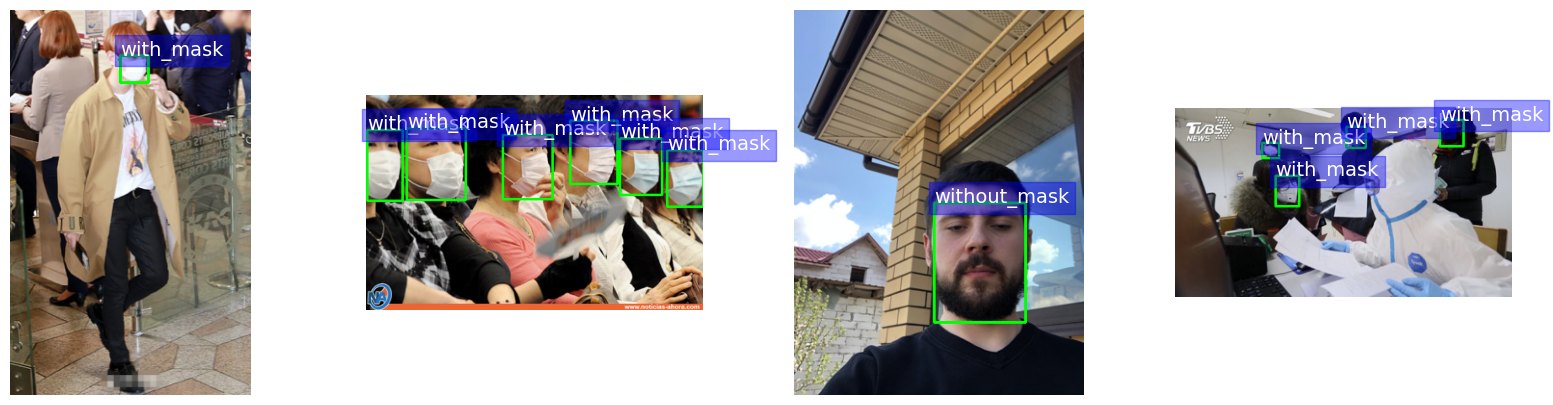

In [23]:
# Each running refreshes images
plot_imgs(train_dataloader, 4)

#Faster R-CNN
There are 4 Faster-RCNN in pytorch, 2 based on Resnet 50 FPN, 2 based on MobileNetV3. We are using the lighter Resnet-50-FPN backbone with 41.8 mln parameters, 134.38 GFLOPS, which is the lighter version of the two Resnet-50-FPN models.

In [24]:
# By default, the model is loaded with three trainable (not frozen) backbone layers starting from the final block.

# Get pretrained model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')

# New predictor with 4 classes (bg + 3 classses)
model.roi_heads.box_predictor = FastRCNNPredictor(1024, 4)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 167MB/s]


In [27]:
def process_epoch(model, optimizer, dataloader, mode='eval'):
    """Processing an epoch,
       returns a loss function for an epoch
    """
    if mode == 'train':
        torch.set_grad_enabled = True
    else:
        torch.set_grad_enabled = False

    batch_losses = [] # Loss function for each batch

    for images, targets in dataloader:
        """ Copying batch data values to GPU/CPU
            and organizing them in the way needed for the model
        """
        images = list(image.to(device) for image in images)
        targets = list({key: val.to(device) for key, val in target.items()}
                       for target in targets)

        # Forward pass
        loss_dict = model(images, targets)
        # Model return 4 diff losses, summing them up
        model_losses = sum(loss_val for loss_val in loss_dict.values())
        # .items() is covertion from a tensor to a simple value
        batch_losses.append(model_losses.items())

        # training step
        if mode =='train':
            optimizer.zero_grad()
            model_losses.backward()
            optimizer.step()
    return np.mean(batch_losses)

def train_model(model, optimizer, train_loader, valid_loader, num_epochs =10):
    """ Model training
    """
    # List to save loss function values and accuracy per epoch
    train_loss, valid_loss = [], []

    fig, ax =plt.subplots(figsize = (8,5))

    # model to train mode
    model.train()

    for epoch in range(num_epochs):
        loss = process_epoch(model, optimizer, train_loader, mode = 'train')
        train_loss.append(loss)
        loss = process_epoch(model, optimizer, valid_loader, mode = 'eval')
        valid_loss.append(loss)

        for _ in range(len(ax.lines)):
            ax.lines[0].remove()
        x_max = len(train_loss)
        ax.plot(range(x_max), train_loss, color = 'b', label = 'train')
        ax.plot(range(x_max), valid_loss, color = 'r', label = 'valid')
        ax.legend()
        ax.set_title('Loss function')
        ex.set_xlabel('Epochs')
        display(fig)
        clear_output(wait=True)

    torch.set_grad_enabled(True)
    return train_loss, valid_loss

In [ ]:
# Training
%%time
model = model.to(device)
params = [p for p in model.parameters() of p.requires_grad]
optimizer = torch.optim.SGD(
          params, lr =.005, momentum =.9, weight_decay=.0005)

train_loss, valid_loss = train_model(
        model, optimizer, train_dataloader, valid_dataloader, num_epochs=25)

# Saving the trained weight
torch.save(model.state_dict(), working/'fasterrcnn.pt')

In [ ]:
""" In case load weight"""
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
#model.roi_heads.box_predictor = FastRCNNPredictor(1024, 4)
#model.load_state_dict(torch.load(SAVED_RESULTS/'fasterrcnn.pt'))
#model.eval()

In [28]:
# Preprocess and plot predictions
def apply_nms(orig_prediction, iou_thresh=.7):
    """ NMS: deleting lower_confident bboxes with IOU > IOU_thresh
    """
    keep =torchvision.ops.nms(
          orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    return final_prediction

def drop_low_confidence(orig_prediction, conf_thresh=.25):
    """Dropping bboxes with low confident scores
    """
    keep = []
    for idx, conf in enumerate(orig_prediction['scores']):
        if conf > conf_thresh:
            keep.append(idx)
    high_conf_preds = orig_prediction
    high_conf_preds['boxes'] = high_conf_preds['boxes'][keep]
    high_conf_preds['scores'] = high_conf_preds['scores'][keep]
    high_conf_preds['labels'] = high_conf_preds['labels'][keep]

def plot_predict(model, dataloader, n_images=4):
    """Shows first n_images from batch
    with GT green and predict boxes Red
    """
    batch = next(iter(dataloader))
    assert n_images <= len(batch[0]), 'No. of images greater than batch size'
    images = batch[0][:n_images]
    targets = batch[1][:n_images]

    # Make a prediction, use CPU
    model = model.to('cpu')
    model.eval()
    with torch.no_grad():
        preds = model(list(images))

    # PLotting
    fig, axes = plt.subplots(1, n_images, figsize=(10*n_images, 10))
    for idx, ax in zip(range(n_images), axes):
        image = image_convert(image[idx])
        image = np.ascontiguousarray(image)
        bboxes_true = targets[idx]['boxes']

        # Extracting bboxes, confident scores, and labels
        high_conf_preds = drop_low_confidence(preds[idx])
        final_preds = apply_nms(high_conf_preds)
        bboxes_preds = final_preds['bboxes']
        labels = final_preds['labels']
        scores = final_preds['scores'] * 100

        # GT boxes
        for i, bbox in enumerate(bboxes_true):
            xmin, ymin, xmax, ymax = (int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3]))
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0,255,0), thickness = 1)

        # Prediction with labels and confidence
        for i, bbox in enumerate(bboxes_preds):
            xmin, ymin, xmax, ymax = (int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3]))
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0,255,0), thickness = 1)
            text = ax.text(xmin, ymin, f'{labels_dict[labels[i]]} : {int(scores[i])}%', fontsize=14, color='w')
            text = text.set_bbox(dict(facecolor='b', alpha=.2, egdecolor='b'))
        ax.axis('off')
        ax.imshow(image)

In [ ]:
plot_predict(model, valid_dataloader, 2)

In [30]:
def compute_mAP(model, dataloader):
    """Compute the mean avg precision over a dataset
    """
    total_preds = []
    total_grtruths = []
    for images, targets in tqdm(dataloader):
        images = list(image.to(device) for image in images)
        target = list(targets)
        total_grtruths.extend(targets)
        model = model.to(device)
        model.eval()
        with torch.no_grad():
            preds = model(images)
        preds = list({key: val.to('cpu') for key, val in pred.items()} for pred in preds)
        high_conf_preds = list(drop_low_confidence(pred) for pred in preds)
        final_preds = list(apply_nms(pred) for pred in high_conf_preds)
        total_preds.extend(final_preds)

    mAP = MeanAveragePrecision(class_metrics=True)
    mAP.update(total_preds, total_grtruths)
    return mAP.compute()

In [ ]:
# Our valid_dataloader loads data in a randomized weighted manner. For metrics evaluation we need the normal sequential loading.
metric_dataloader = torch.utils.DataLoader(
      valid_dataset,
      batch_size = FRCNN_BATCH_SIZE,
      num_workers=os.cpu_count(),
      collate_fn = collate_fn
)

mAP = compute_mAP(model, metric_dataloader)
pprint(mAP)

# YOLOv8

In [40]:
!mkdir YOLO_DATA
YOLO_DATA = Path('/content/YOLO_DATA')

mkdir: cannot create directory ‘YOLO_DATA’: File exists


In [37]:
# Unlike in the previous case of manual transmission,
# here the job is basically the copy-pasting of images from one folder to another.
def convert_to_yolov8(df, train):
    """
    Copying annotation adn copying selected images to
    specials "train-valid" folders for YOLO training
    """
    ## bboxes coordinates to YOLO format
    df['x_center'] = (df['xmin'] + df['xmax']) / 2 / df['width']
    df['y_center'] = (df['ymin'] + df['ymax']) / 2 / df['height']
    df['bb_width'] = (df['xmax'] - df['xmin']) / df['width']
    df['bb_height'] = (df['ymax'] - df['ymin']) / df['height']

    for image in tqdm(df['filename'].unique()):
        if train:
            imfolder = YOLO_DATA/'images/train'
            label_folder = YOLO_DATA/'labels/train'
        else:
            imfolder = YOLO_DATA/'images/valid'
            label_folder = YOLO_DATA/'labels/valid'
        # copying images to yolo folders
        shutil.copy(DATA/'images'/image, imfolder)

        # making .txt file with the bboxes parameter
        mask = df['filename'] == image
        out_df = (df[mask][['label', 'x_center', 'y_center', 'bb_width', 'bb_height']])
        filename = label_folder/image.replace('png', 'txt')
        out_df.to_csv(filename, sep=' ', header=False, index=False)

In [42]:
# In YOLO class index start from 0
# New numberation
train_df['label'] = train_df['label'] - 1
valid_df['label'] =  valid_df['label'] -1
labels_dict = dict(zip(range(len(encoder.classes_)), encoder.classes_))

# YOLOv8
Path(YOLO_DATA/'images/train').mkdir(parents=True, exist_ok= True)
Path(YOLO_DATA/'images/valid').mkdir(parents=True, exist_ok= True)
Path(YOLO_DATA/'labels/train').mkdir(parents=True, exist_ok= True)
Path(YOLO_DATA/'labels/valid').mkdir(parents=True, exist_ok= True)
convert_to_yolov8(train_df, train=True)
convert_to_yolov8(valid_df, train=False)

100%|██████████| 171/171 [00:00<00:00, 172.54it/s]


In [51]:
# Configuration file for custom dataset
text = """
names:
0 = weared_incorrectly
1: mask
2: no_mask
"""
with open('mask_detection.yaml', 'w') as f:
    f.write(f"train: {YOLO_DATA/'images/train'}\n")
    f.write(f"val: {YOLO_DATA/'images/valid'}\n")
    f.write(text)

choosen the "medium" model with  
26 mln parameters as a tradeoff between the high performance (mAP50-95 =
0.5
  on COCO dataset) and the  79
  GFLOPs. The next-grade model takes  165
  GFLOPS (two times more) with  3
%
  of mAP growth (to  0.53
 ).

In [52]:
model =YOLO('yolov8m.pt')

100%|██████████| 49.7M/49.7M [00:00<00:00, 310MB/s]


In [56]:
!pip install wandb -qU
# Log in to your W&B account
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
%%time
model.train(
    data='mask_detection.yaml', batch =-1, #Batch -1 means that the batch size is calculated automatically.
    epochs = 25, workers = os.cpu_count()
)

In [ ]:
def plot_predict_yolo(model, dataloader, n_images=2):
    """Shows first 'n_images' from a batch
       with ground truth (green) and prediction (red) bboxes
    """
    batch = next(iter(dataloader))
    assert n_images <= len(batch[0]), 'No. of images greater than batch size'
    images = batch[0][:n_images]
    targets = batch[1][:n_images]

    fig, axes = plt.subplots(1, n_images, figsize=(10*n_images, 10))
    for idx, ax in zip(range(n_images), axes):
       image = image_convert(images[idx])
       image = np.ascontiguousarray(image)
       with torch.no_grad():
           preds = model(image)

       bboxes_true = targets[idx]['boxes']
       bboxes_pred = preds[0].boxes.xyxy.to('cpu')
       labels = preds[0].boxes.cls.to('cpu').numpy()
       scores = preds[0].boxes.conf.to('cpu') * 100

       # Ground truth bboxes
       for i, bbox in enumerate(bboxes_true):
           xmin, ymin, xmax, ymax = (int(bbox[0]), int(bbox[1]),
                                     int(bbox[2]), int(bbox[3]))
           cv2.rectangle(image, (xmin, ymin), (xmax, ymax),
                             (0, 255, 0), thickness=1)

       # Predictions with labels and confidence
       for i, bbox in enumerate(bboxes_pred):
           xmin, ymin, xmax, ymax = (int(bbox[0]), int(bbox[1]),
                                     int(bbox[2]), int(bbox[3]))
           cv2.rectangle(image, (xmin, ymin), (xmax, ymax),
                         (255, 0, 0), thickness=1)
           text = ax.text(xmin, ymin, f'{labels_dict[labels[i]]}: {int(scores[i])}%',
                          fontsize=14, color='w')
           text.set_bbox(dict(facecolor='b', alpha=0.2, edgecolor='b'))

       ax.axis('off')
       ax.imshow(image)

In [ ]:
plot_predict_yolo(model, valid_dataloader)

|Model |No. of parameters | GFLOPS | mAP |	minor class AP |	mAP50 |	One epoch training time
|---|---|---|---|---|---|---|
|Faster R-CNN |	41.8 mln |	134 |	0.53 |	0.39 |	0.79 |	2.4 min |
|YOLOv8	|25.9 mln	|79	|0.68	|0.69	|0.92	|0.5 min|